# Customer Churn Prediction and Prevention, with Boosted Decision Trees (BDT) and Neural Networks

#### **_If you could predict which customers will leave your business, what would you do to keep them? Using AI-powered machine learning, I analyze churn drivers and propose targeted retention strategies._**



**Overview**: Losing (churning) customers costs money, and signing new customers is more expensive than retaining existing customers.  I analysis a dataset which captures a snapshot of customers at a central European bank in order to predict which customers are most likely to churn ([Kaggle, Bank Customer Churn](https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn/data)). The dataset includes customer use of bank products, their personal profiles, and their financial status. Through my analysis, I build a profile of churning customers and understand the most relevant factors in their decision to leave, in order to advise on business actions the bank can take to prevent this and retain custom.

**Methodology**: I utilise Exploratory Data Analysis (EDA) to get a meaningful understanding of the data and to make key predictions for customer churn.  I then train and optimise (with [Optuna](https://optuna.org/)) two Machine Learning classification algorithms to make predictions on unseen cross-validation and test datasets:
- Boosted Decision Tree (BDT) with [XGBoost](https://xgboost.readthedocs.io/en/stable/)
- Neural Network with [Tensorflow](https://www.tensorflow.org/)

I cross-check the ML algorithms against my EDA insights through the importance of different features in the data, using [SHAP Values](https://shap.readthedocs.io/en/latest/index.html).

**Key Business Insights**: The main casual indicators for customers to churn, confirmed by EDA and both ML algorithms, are:
- Age (45+)
- High-balance accounts
- High product use
- Location (Germany)
- Gender (females slightly more likely to leave than males)

The conclusion of this study is that this bank failed to retain older wealthier customers with high product use. These are customers who were highly engaged and may have expected VIP treatment. Almost every customer who churns also leaves a complaint with the bank, suggesting a degree of dissatisfaction with the service.

To retain such customers in the future <span style="color:red">**I would recommend the following actions:**</span>

- **Exclusive benefits for high-balance customers with multiple products**:
  - Priority Customer Services
  - Premium Credit Cards
  - Wealth Tiers and Loyalty Benefits
- **Specialised offers for older customers**:
  - Retirement Savings Accounts
  - Fixed-Income Investment Plans
  - Personalised Financial Advisory Services
- **Localised strategies for German customers**
  - Survey German customers to understand why they are leaving

If the bank wishes to perform more targeted interventions, the predictions of the ML algorithms may be used to provide a list of high-churn-risk customers to contact. This would be a worthwhile effort: the prediction has a 69% precision meaning that the majority of calls made will be to customers who are planning to leave, this maximises the customer service efficiency without hassling the vast majority of customers who intend to stay. Further, the prediction has a 60% churning-customer recall, meaning that the majority of customers who are planning to leave will be included in the high-churn-risk list.

**Contact**

If you have any questions, feel free to connect with me on [LinkedIn](https://www.linkedin.com/in/jacob-kempster-b75628114/) or check out the below for a deeper dive into this case study!

#### **_What strategies has your business used to retain high-value customers? Let me know in the comments!_**


# The Nitty Gritty - How these insights were achieved 
## Setup and imports

In [ ]:
import sys, os, warnings
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.activations import linear, relu, sigmoid
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
import optuna
import pandas as pd
import numpy as np
import time
import math
import random
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, f1_score, roc_curve, roc_auc_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
import shap
from IPython.display import display, Markdown

#suppress logging for clean notebook
optuna.logging.set_verbosity(optuna.logging.WARNING)  # Hide most messages
xgb.set_config(verbosity=0)  # 0 = Silent, 1 = Warning, 2 = Info, 3 = Debug
tf.get_logger().setLevel("ERROR")  # Suppress TF logs
tf.autograph.set_verbosity(0)  # Suppress Autograph messages
logging.getLogger("tensorflow").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # Suppress even more warnings
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # (Optional) Disable GPU logs if needed
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/usr/local/cuda-12.6"  # Ensure proper CUDA linking
sys.stderr = open(os.devnull, "w")

# Set random seeds
SEED = 42  # Pick any number

np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Ensure TensorFlow operations use deterministic algorithms (optional)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = str(SEED)

## Exploratory Data Analysis (EDA)

The dataset contains information on 100000 customers, with an approximately churn rate of 20% (captured by the 'Exited' status). Multiple features related to the customer ID are not useful predictors and are removed.
Multiple features (Gender, Geographical location, Card Type) may be simplified into numerical data using one-hot encoding.

The correlation matrix shows the basic pearson correlation coefficient, as an indicator of the strength of the relationshiop between each pair of features - including the final status of customer retention / churn.
Curiously, the "Complain" feature is found to have a near-perfect correspondence with the customer's decision to churn.  Depsite this high-correlation, **complaints is not a useful predictor for churn**.  The most likely circumstance is that dissatisfied customers leave a complaint as their close their accounts with the bank, i.e. if a complaint has been made it is likely already too late to retain the customer's business.  As such, this feature will be removed from later consideration.

However, it is useful to note that 'Complain' (and subsequently 'Exited') has noteable correlations with other features which give some initial useful hints on customer segments to consider. In order of correlation magnitude:
- Age (older customers more likely to leave)
- Geography (customers in Germany more likey to leave, customers in France less likely to leave)
- Activity (inactive customers more likely to leave)
- Balance (wealthier customers more likely to leave)
- Gender (female customers more likely to leave)


In [2]:
df = pd.read_csv('../../Datasets/BankCustomerChurn/Customer-Churn-Records.csv')
#inspect the data
print(df[:5].to_string())
print(df['Exited'].value_counts())

#grab the targets into their own dataframe
y = df['Exited']
y = y.astype(int)

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited  Complain  Satisfaction Score Card Type  Point Earned
0          1    15634602  Hargrave          619    France  Female   42       2       0.00              1          1               1        101348.88       1         1                   2   DIAMOND           464
1          2    15647311      Hill          608     Spain  Female   41       1   83807.86              1          0               1        112542.58       0         1                   3   DIAMOND           456
2          3    15619304      Onio          502    France  Female   42       8  159660.80              3          1               0        113931.57       1         1                   3   DIAMOND           377
3          4    15701354      Boni          699    France  Female   39       1       0.00              2          0               0         93826.63       0

In [3]:
#Let's make a copy of the data that ignores the non-useful columns as a feature vector
excludeCols = ["RowNumber","CustomerId","Surname","Exited"]

features_tmp_df = df.drop(columns=excludeCols).copy()

#Let's do some one-hot encoding
#Closed-categories should utilise drop-first logic to reduce dimensionality.
drop_first_cols = ["Gender"]
#one-hot-keep-all
keep_first_cols = ["Geography","Card Type"]

# One-hot encoding with drop_first=True for specific columns
df_gender_encoded = pd.get_dummies(features_tmp_df[drop_first_cols], drop_first=True)

# One-hot encoding without drop_first for other columns
df_onehot_encoded = pd.get_dummies(features_tmp_df[keep_first_cols], drop_first=False)

features_df = features_tmp_df.drop(columns=drop_first_cols + keep_first_cols) #filter out those which are being encoded
features_df = pd.concat([features_df,df_gender_encoded,df_onehot_encoded], axis=1) #stick it all back together

# Convert all boolean columns to integers (0 and 1)
features_df = features_df.astype(int)

print(features_df)

      CreditScore  Age  Tenure  Balance  NumOfProducts  HasCrCard  \
0             619   42       2        0              1          1   
1             608   41       1    83807              1          0   
2             502   42       8   159660              3          1   
3             699   39       1        0              2          0   
4             850   43       2   125510              1          1   
...           ...  ...     ...      ...            ...        ...   
9995          771   39       5        0              2          1   
9996          516   35      10    57369              1          1   
9997          709   36       7        0              1          0   
9998          772   42       3    75075              2          1   
9999          792   28       4   130142              1          1   

      IsActiveMember  EstimatedSalary  Complain  Satisfaction Score  \
0                  1           101348         1                   2   
1                  1         

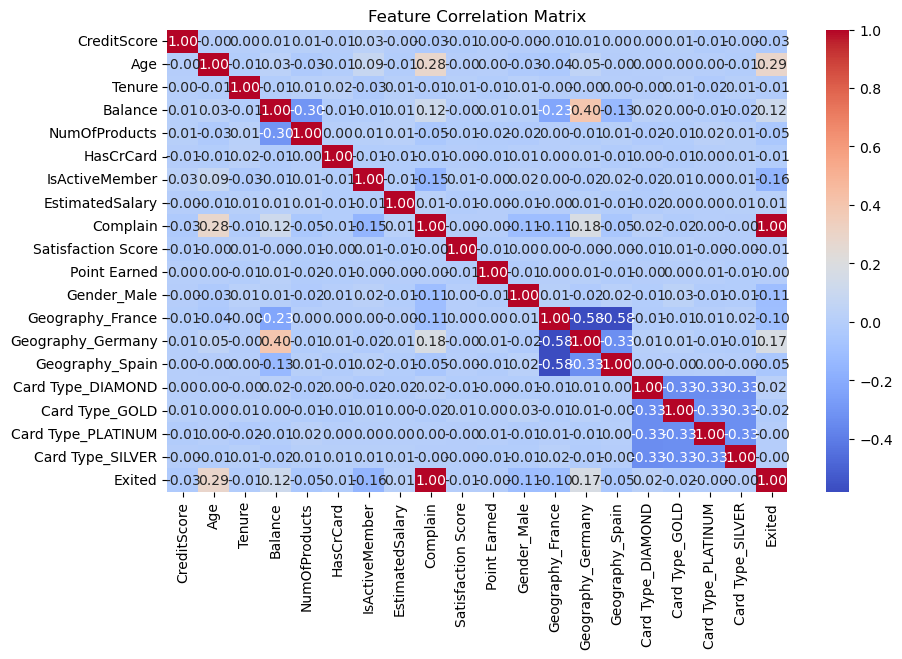

In [4]:
#Inspect correlations to get initial feel for the dataset - temporarily add the Exited status back on
tmpFeats = features_df.copy()
tmpTarg = y.copy()
tmpFeats["Exited"] = y
corr_matrix = (tmpFeats).corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

In [5]:
#We're dropping 'Complain' here, as it turns out to be a near-perfect predictor of customer churn.  That suggests that actually this is a complaint
#made by a customer as they are leaving, i.e. not an actionable feature.  It would be better to predict churn _before_ the customer has a reason to
#complain and then to approach them proactively with the goal of retention
excludeCols = ["Complain"]

features_df = features_df.drop(columns=excludeCols).copy()

Briefling highlighting the customer Age in particular, it is important to note that the mean age for customers leaving the bank is just over 45 years. This indicates that leaving is a conscious decision, i.e. not a side-effect of unfortunate events such as end-of-life.

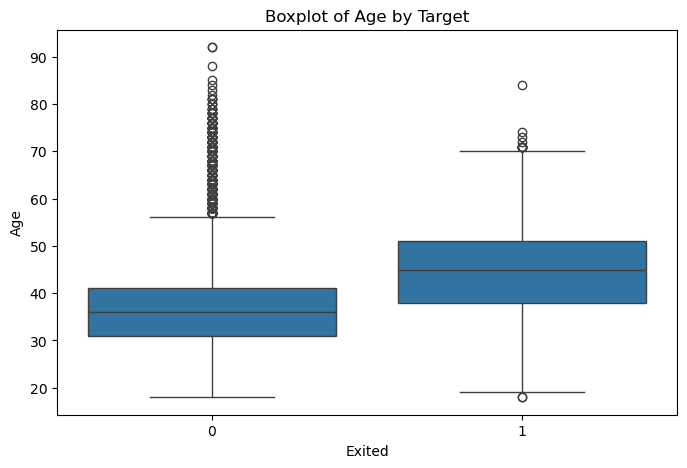

In [6]:
plt.figure(figsize=(8, 5))
sns.boxplot(x="Exited", y="Age", data=df)
plt.title(f"Boxplot of Age by Target")
plt.show()


It is extremely useful to get a fast overview of the dataset, using histograms to separate the behaviour of customers who churn and customers who are retained. This can give fast indicators for further features to focus on.

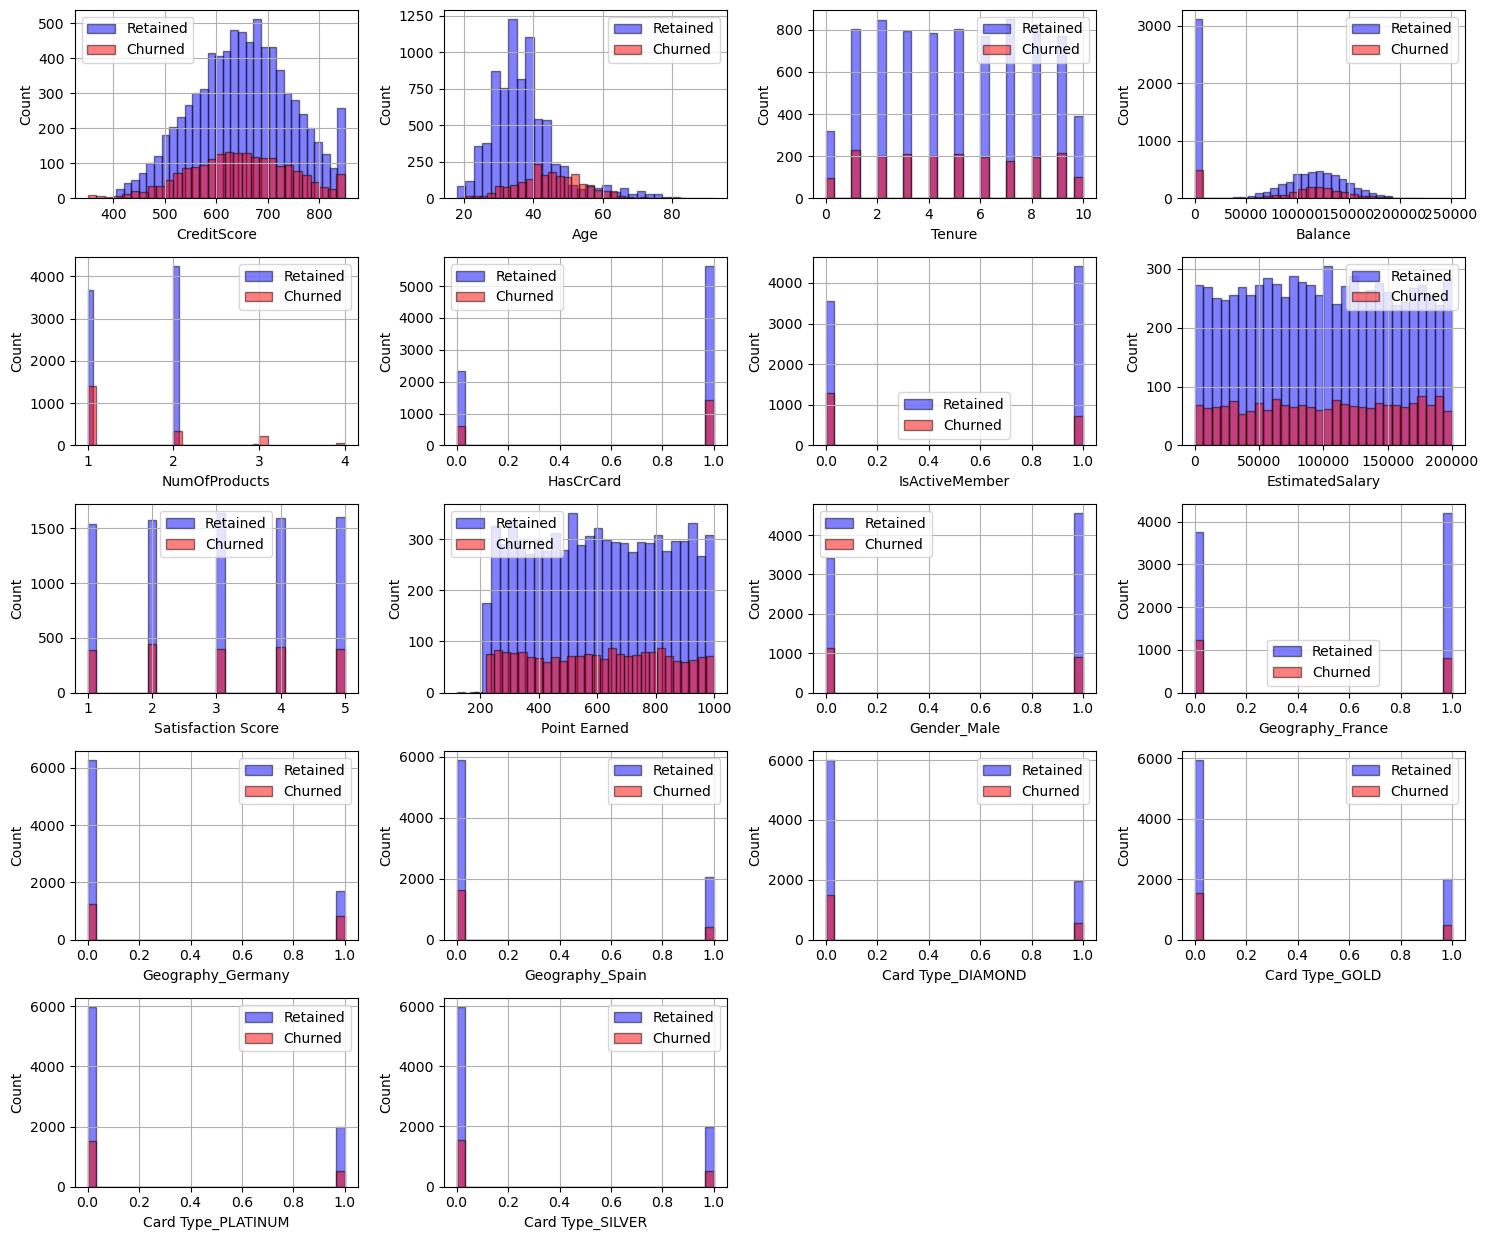

In [7]:
#let's use subplots to make a load of comparisons side by side - this time for histograms
num_features = len(features_df.columns)
num_cols = 4
num_rows = math.ceil(num_features / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize = (15, 2.5* num_rows))

axes = axes.flatten() if num_features > 1 else [axes]

for i, feature in enumerate(features_df.columns):
    feature_exited_0 = features_df.loc[y==0,feature]
    feature_exited_1 = features_df.loc[y==1,feature]
    
    axes[i].hist(feature_exited_0, bins=30, color='blue', edgecolor='black', alpha=0.5, label="Retained")
    axes[i].hist(feature_exited_1, bins=30, color='red', edgecolor='black', alpha=0.5, label="Churned")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Count")
    axes[i].set_title=(f"Histogram of {feature} by Client Status")
    axes[i].legend()
    axes[i].grid(True)

#hide any unecessary subplots (i.e. num_features doesn't fit perfectly into num_rows*num_cols)   
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

From the plots above, one further feature of interest is noteable: the 'Number of Products' a customer uses increases their likelihood to churn.  This is counter-intuitive, with some possible explanations which lead in opposite directions:
- Customers who engage with more products may be more serious about maximising their wealth, and are disatisfied by the products provided by the bank or prefer the options of a competitor's service.
  - **Potential business action:** Survey wealthier customers to tailor products to their needs e.g. preferential interests rates for high-value accounts.
- Customers who engage with more products may be struggling financially and trying to benefit maximally from what is at their disposal, but ultimately leave due to financial problems.
  - **Potential business action:** Survey struggling customers to tailor products to support them, e.g. financial advice and planning tools.
 
It is useful to consider this further by inspecting relevant distributions only for customers who use 3 or more products from the bank and choose to leave. The histograms below are normalised to unit area. 

In [8]:
#Plot interesting features split by feature of choice

def plotInterestingFeaturesWithSplit(thisFeature, splitVal, lowLabel, highLabel):

    interestingFeatures = ["Age","Balance","EstimatedSalary","Gender_Male","Geography_Germany","NumOfProducts"]

    interestingFeatures.remove(thisFeature)
    
    num_features = len(interestingFeatures)
    num_cols =  num_features
    num_rows = 1

    fig, axes = plt.subplots(num_rows, num_cols, figsize = (15, 2.5* num_rows))

    axes = axes.flatten() if num_features > 1 else [axes]

    for i, feature in enumerate(interestingFeatures):

        feature_low = features_df.loc[(y==1) & (features_df[thisFeature] < splitVal), feature]
        feature_high = features_df.loc[(y==1) & (features_df[thisFeature] >= splitVal), feature]

        axes[i].hist(feature_low, bins=30, color='green', edgecolor='black', alpha=0.5, label=lowLabel,density=True)
        axes[i].hist(feature_high, bins=30, color='pink', edgecolor='black', alpha=0.5, label=highLabel, density=True)
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel("Normalised Count")
        axes[i].set_title=(f"Histogram of {feature} by Client Status")
        axes[i].legend()
        axes[i].grid(True)

    #hide any unecessary subplots (i.e. num_features doesn't fit perfectly into num_rows*num_cols)   
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

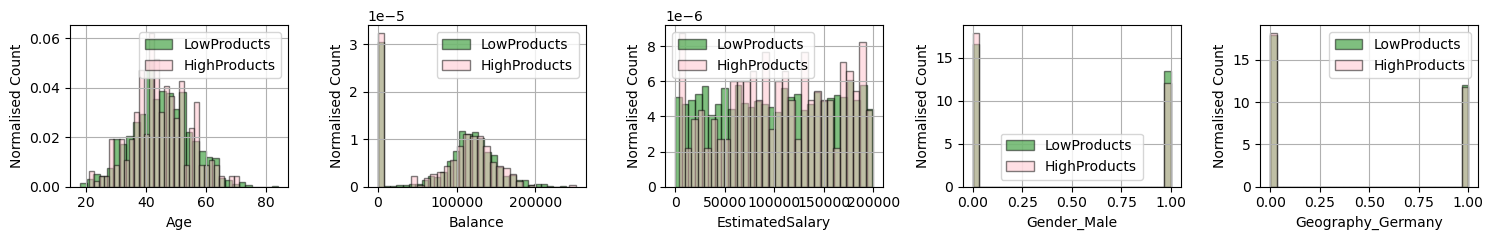

In [9]:
plotInterestingFeaturesWithSplit("NumOfProducts",3,"LowProducts","HighProducts")

These plots reveal no strong connections between the wealth or age of a client and their likelihood to use additional products.  This is an indicator that **that the use of additional products may be a causal feature for customers leaving the bank**, which is a serious problem.
- <span style="color:red">**Business action**:</span>  Investigate whether the products available are value for money and easily useable, compare these to competitor's offerings.

- It is equally useful to break down each of these interesting features further, to see if any are consistently correlated.  The plots below highlight only those customers who leave the bank.  They are useful to answer questions such as:
- Are older customers who leave consistently based in Germany?
- Are German customers who leave consistently female?
- Are female customers who leave consistently wealthier?

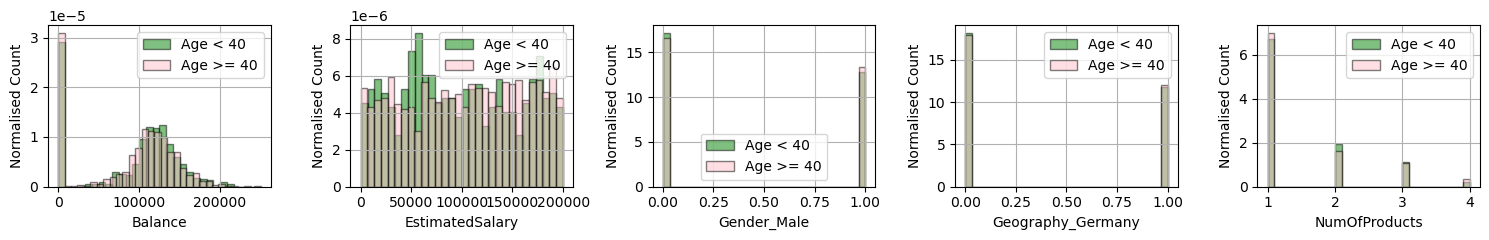

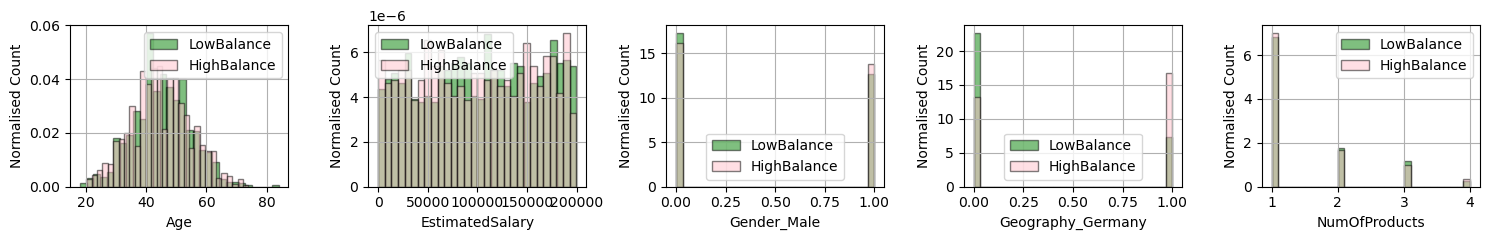

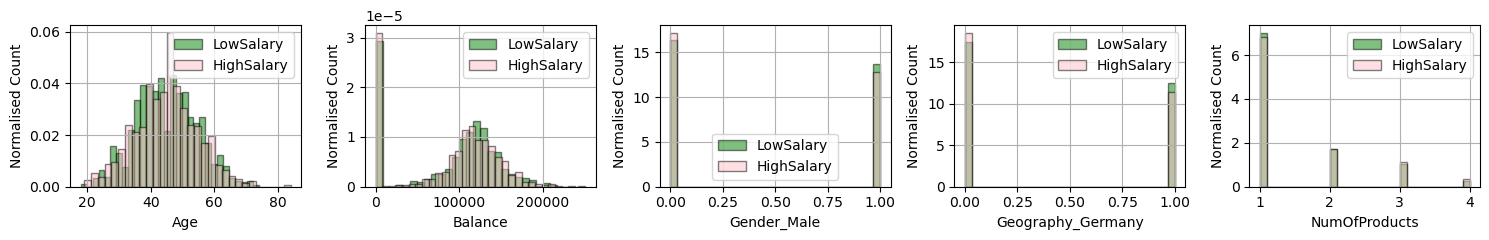

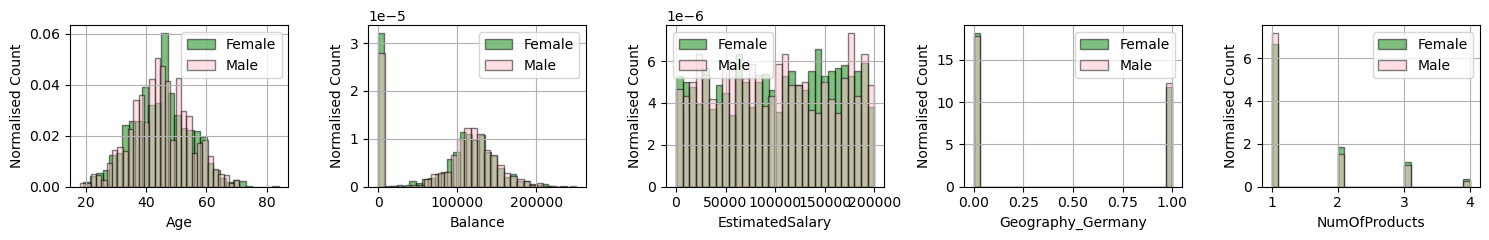

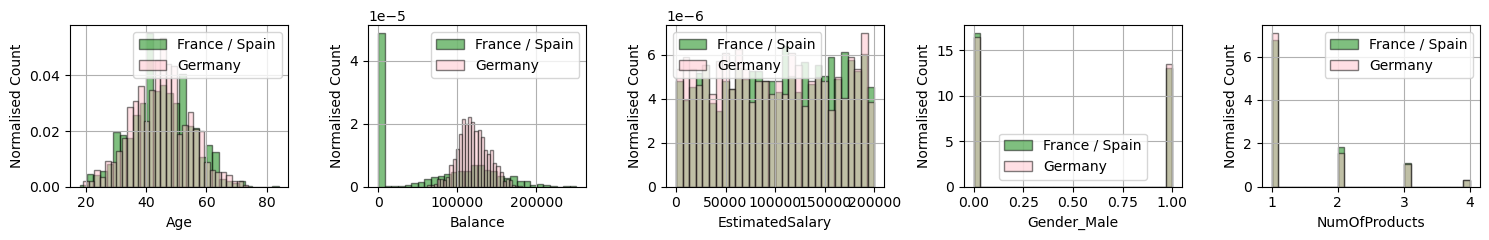

In [10]:
plotInterestingFeaturesWithSplit("Age",40,"Age < 40","Age >= 40")
plotInterestingFeaturesWithSplit("Balance",110000,"LowBalance","HighBalance")
plotInterestingFeaturesWithSplit("EstimatedSalary",100000,"LowSalary","HighSalary")
plotInterestingFeaturesWithSplit("Gender_Male",0.5,"Female","Male")
plotInterestingFeaturesWithSplit("Geography_Germany",0.5,"France / Spain","Germany")

The key insight achieved is the consistent prevalance of customers with a higher balance in Germany, or to be more precise, a lack of customers with a low balance in Germany.  The age distribution of customers in Germany is in agreement with that of customers in Spain and France.

Following the thread, we can look at the probability for wealthier German customers to churn. This reveals that 36% of customers in this category are lost, which is much higher than the average for the dataset as a whole. This increases to almost 41% of wealthier German female customers. This information, all put together, leads to the idea that **the primary customer churn occurs in (female) customers based in Germany**. It is important to note that while these customers tend to be older, but are not exclusively so.
- <span style="color:red">**Business action**:</span>  Survey the particular needs of wealthier customers based in Germany, with a focus on female customers.

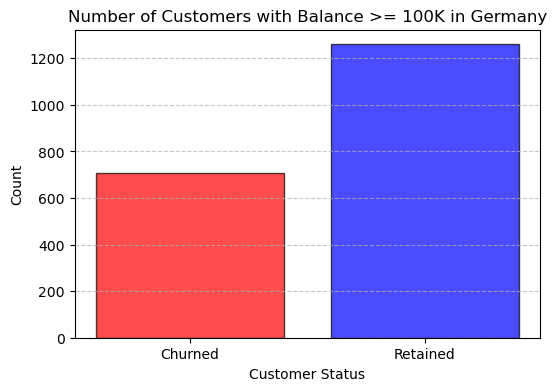

In [11]:
num_churned = len(features_df.loc[(y==1) & (features_df["Balance"] >= 100000) & (features_df["Geography_Germany"] == 1)])# & (features_df["Gender_Male"] == 0)])
num_retained = len(features_df.loc[(y==0) & (features_df["Balance"] >= 100000) & (features_df["Geography_Germany"] == 1)])# & (features_df["Gender_Male"] == 0)])

categories = ["Churned","Retained"]
counts = [num_churned,num_retained]

plt.figure(figsize=(6,4))
plt.bar(categories, counts, color=["red", "blue"], edgecolor='black', alpha=0.7)

#Labels and title
plt.xlabel("Customer Status")
plt.ylabel("Count")
plt.title("Number of Customers with Balance >= 100K in Germany")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

## Predicting customer churn using Machine Learning

With a solid understanding of the data, it is possible to proceed with machine learning solutions to build predictive models of customer churn as a classification task. There are several key considerations to work with this dataset:
- The amount of data available is not large (10k customers) - therefore it is important not to overtrain.
- The dataset is highly imbalanced, with only 20% of customers churning - therefore this imbalance must be addressed to ensure the solution focuses on this Positive Class appropriately.
- The data types span several orders of magnitude - therefore feature scaling is important to mitigate inappropriate focus on numerically larger features.
- There is no missing or corrupt data.

### Splitting into training, cross-validation and testing sets, and applying feature scaling

In [12]:
#Let's split into train, test and validation 
#handle data shuffling

#first split to define training set
X_train, X_, y_train, y_ = train_test_split(features_df, y, test_size = 0.4, random_state=SEED)

#second split to define cross-validation and testing sets
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.5, random_state=SEED)

print("X_train.shape:", X_train.shape, "X_cv.shape:", X_cv.shape, "X_test.shape:", X_test.shape)

X_train.shape: (6000, 18) X_cv.shape: (2000, 18) X_test.shape: (2000, 18)


In [13]:
#How many positive class and negative class cases in each of the train, test and validation sets?

print(f"Training set is {100* sum(y_train) / len(y_train):.2f}% churned customers.")
print(f"CV set is {100* sum(y_cv) / len(y_cv):.2f}% churned customers.")
print(f"Test set is {100* sum(y_test) / len(y_test):.2f}% churned customers.")

Training set is 20.47% churned customers.
CV set is 19.00% churned customers.
Test set is 21.50% churned customers.


In [14]:
#Let's rescale a lot of the features to prepare them for training, and plot again also.  Let's retain the Pandas Dataframes column names too.
scaler = preprocessing.StandardScaler()
X_norm = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

#scale the other sets as well
X_cv_norm = pd.DataFrame(scaler.transform(X_cv), columns=X_cv.columns)
X_test_norm = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

### Training a BDT with hyperparameter optimisation

A BDT is a natural choice for this dataset as it is all numerical data which can be used in simple categorical selections. [XGBoost](https://xgboost.readthedocs.io/en/stable/) is a popular package for efficiently training BDTs, while [Optuna](https://optuna.org/) is a fantastic tool to accelerate the optimisation of hyperparameters.

Below I train a BDT to perform binary classification, predicting whether individual customers are likely to leave the bank. I take into account the 1:4 class imbalance in the data by scaling the weight of the Positive Class (churned customers) by approximately 4.0. Further, I use Optuna to optimise the hyperparameters of the BDT:

- Number of Estimators: The total number of decision trees trained per ensemble.  More trees improve learning but increase computation time and the risk of over-fitting.
- Learning Rate: Controls how much each tree contributes to the final prediction, balances over-fitting with generalisation and learning speed.
- Maximum Depth: The number of decision splits each tree may perform, balances complexity with over-fitting.
- Subsample: The fraction of training data used per tree, to mitigate over-fitting.
- Colsample: The fraction of features used oer ptree, to mitigate over-fitting.
- Scale Weight: Reweights the minority class (Positive cases) to improve the attention of the BDT to correctly classifying this data

Optuna is given the target to maximise the ROC-AUC score, that is to maximise the True Positive Rate (recall) while minimising the False Positive Rate. This should result in the best classification separation between churning and non-churning customers, and importantly it is not affected by the initial class imbalance.


In [15]:
#Let's use optuna to optimise the hyperparameters of an XGBoost BDT from the get-go

#X_norm_np = np.array(X_norm)
#y_train_np = np.array(y_train)
#X_cv_norm_np = np.array(X_cv_norm) #convert to numpy array
#y_cv_np = np.array(y_cv) #convert to numpy array

def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 3.0, 5.0), #handling class imbalance
        'early_stopping_rounds': 20,
        'random_state': SEED,
        'seed': SEED
    }

    model = xgb.XGBClassifier(**params)

    model.fit(
        X_norm, y_train,
        eval_set=[(X_norm, y_train), (X_cv_norm, y_cv)],
        verbose=False
    )

    y_pred_proba = model.predict_proba(X_cv_norm)[:,1]

    auc = roc_auc_score(y_cv, y_pred_proba)

    return auc #for optuna to maximise

In [16]:
#Run Optuna
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(objective, n_trials=50)

In [17]:
print("Best Parameters:", study.best_params)

Best Parameters: {'n_estimators': 319, 'learning_rate': 0.029109714319387876, 'max_depth': 3, 'subsample': 0.9166800371457215, 'colsample_bytree': 0.668390935609242, 'scale_pos_weight': 4.087309185793522}


In [18]:
#X_test_norm_np = np.array(X_test_norm)
#y_test_np = np.array(y_test)

#train with the best parameters
best_params_BDT = study.best_params
best_model_BDT = xgb.XGBClassifier(**best_params_BDT)
best_model_BDT.fit(
    X_norm, y_train,
    eval_set=[(X_norm, y_train), (X_cv_norm, y_cv)],
    verbose=False
)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.668390935609242, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.029109714319387876,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=319, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Having trained the model, we can now consider the BDT output score as a proability for a customer to churn.  We have freedom to interpret this score and to set the threshold above which we consider the probability to churn to be high enough to classifying this customer in the Positive class. For this I implement the F1-score, which gives the optimal balance between the Precision and Recall of the algorithm.

Best Threshold for Precision-Recall Balance: 0.667


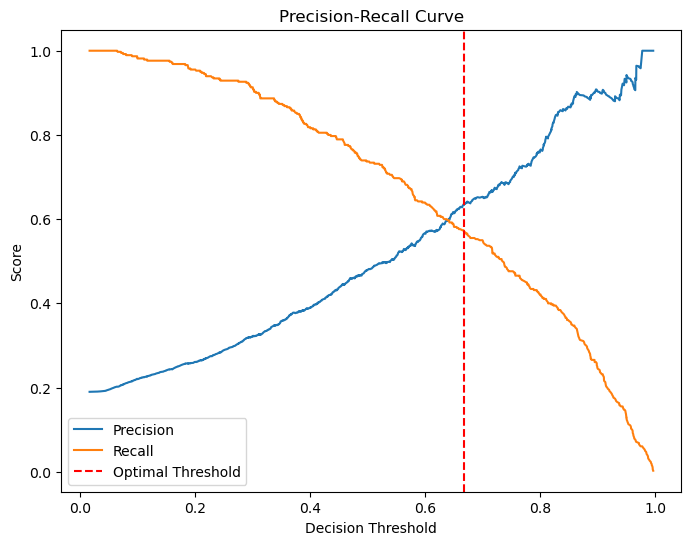

In [19]:
# Get predicted probabilities from the best model
y_cv_pred_proba_BDT = best_model_BDT.predict_proba(X_cv_norm)[:, 1]  # Probabilities

# Calculate precision-recall values for different thresholds
precisions, recalls, thresholds = precision_recall_curve(y_cv, y_cv_pred_proba_BDT)

# Compute F1-score for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_threshold_BDT = thresholds[np.argmax(f1_scores)]

print(f"Best Threshold for Precision-Recall Balance: {best_threshold_BDT:.3f}")

# Plot Precision-Recall Curve
plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.axvline(x=best_threshold_BDT, color="r", linestyle="--", label="Optimal Threshold")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision-Recall Curve")
plt.show()


With the optimal decision threshold, it is now straight forward to use the BDT to make predictions for every customer in the dataset and consider the overall performance of the BDT. The scores below all indicate a very slight over-training of the algorithm, which could be mitigated through further optimisation.

In [20]:
# let's use the new threshold determined above 
y_train_proba_BDT = best_model_BDT.predict_proba(X_norm)[:, 1]  # Probabilities
auc_train_score_BDT = roc_auc_score(y_train, y_train_proba_BDT)
y_train_pred_BDT = (y_train_proba_BDT >= best_threshold_BDT).astype(int) #Predictions

y_cv_proba_BDT = best_model_BDT.predict_proba(X_cv_norm)[:, 1]  # Probabilities
y_cv_pred_BDT = (y_cv_proba_BDT >= best_threshold_BDT).astype(int) #Predictions
auc_cv_score_BDT = roc_auc_score(y_cv, y_cv_proba_BDT)


y_test_proba_BDT = best_model_BDT.predict_proba(X_test_norm)[:, 1]  # Probabilities
y_test_pred_BDT = (y_test_proba_BDT >= best_threshold_BDT).astype(int) #Predictions
auc_test_score_BDT = roc_auc_score(y_test, y_test_proba_BDT)


# Training Set Metrics
train_acc_BDT = accuracy_score(y_train, y_train_pred_BDT)
train_precision_BDT = precision_score(y_train, y_train_pred_BDT)
train_recall_BDT = recall_score(y_train, y_train_pred_BDT)
train_f1_BDT = f1_score(y_train, y_train_pred_BDT)

# Cross-Validation Set Metrics
cv_acc_BDT = accuracy_score(y_cv, y_cv_pred_BDT)
cv_precision_BDT = precision_score(y_cv, y_cv_pred_BDT)
cv_recall_BDT = recall_score(y_cv, y_cv_pred_BDT)
cv_f1_BDT = f1_score(y_cv, y_cv_pred_BDT)

# Test Set Metrics
test_acc_BDT = accuracy_score(y_test, y_test_pred_BDT)
test_precision_BDT = precision_score(y_test, y_test_pred_BDT)
test_recall_BDT = recall_score(y_test, y_test_pred_BDT)
test_f1_BDT = f1_score(y_test, y_test_pred_BDT)


# Create a dictionary of model scores
metrics_data = {
    "Dataset": ["Training", "Cross-Validation", "Test"],
    "Accuracy": [train_acc_BDT, cv_acc_BDT, test_acc_BDT],
    "Precision": [train_precision_BDT, cv_precision_BDT, test_precision_BDT],
    "Recall": [train_recall_BDT, cv_recall_BDT, test_recall_BDT],
    "F1-Score": [train_f1_BDT, cv_f1_BDT, test_f1_BDT],
    "ROC-AUC": [auc_train_score_BDT, auc_cv_score_BDT, auc_test_score_BDT]
}

# Convert to DataFrame
df_metrics = pd.DataFrame(metrics_data)

# Convert to Markdown table format
markdown_table = df_metrics.to_markdown(index=False, floatfmt=".4f")

# Display in Jupyter Notebook
display(Markdown(markdown_table))

| Dataset          |   Accuracy |   Precision |   Recall |   F1-Score |   ROC-AUC |
|:-----------------|-----------:|------------:|---------:|-----------:|----------:|
| Training         |     0.8677 |      0.6955 |   0.6287 |     0.6604 |    0.8943 |
| Cross-Validation |     0.8565 |      0.6356 |   0.5737 |     0.6030 |    0.8568 |
| Test             |     0.8555 |      0.6860 |   0.6047 |     0.6428 |    0.8669 |

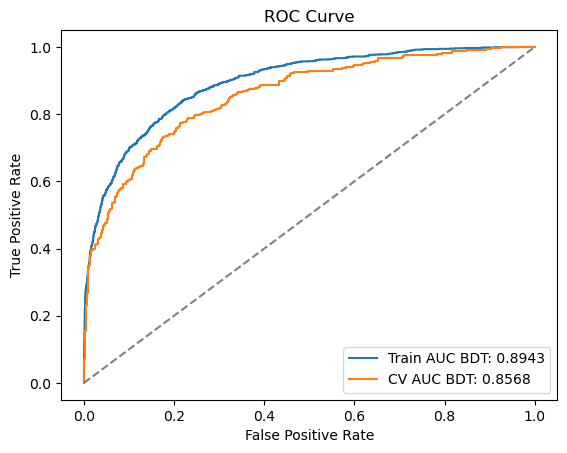

In [21]:
# Compute AUC Score
train_auc_BDT = roc_auc_score(y_train, y_train_proba_BDT)
cv_auc_BDT = roc_auc_score(y_cv, y_cv_proba_BDT)

# ROC Curve
fpr_train_BDT, tpr_train_BDT, _ = roc_curve(y_train, y_train_proba_BDT)
fpr_cv_BDT, tpr_cv_BDT, _ = roc_curve(y_cv, y_cv_proba_BDT)

plt.plot(fpr_train_BDT, tpr_train_BDT, label=f"Train AUC BDT: {train_auc_BDT:.4f}")
plt.plot(fpr_cv_BDT, tpr_cv_BDT, label=f"CV AUC BDT: {cv_auc_BDT:.4f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")  # Random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [22]:
#Confusion matrix
cm_BDT = confusion_matrix(y_test, y_test_pred_BDT)
cm_percentage_BDT = 100* cm_BDT.astype("float") / cm_BDT.sum(axis=1, keepdims=True)

For binary classification problems Confusion Matrices are valuable tools for quickly understanding the performance of the classification decisions. The BDT does a fantastic job of surpressing False Positives, only mis-classifying 7.6% of True Negatives.  It is also able to successfully classify 60.5% of True Positives.

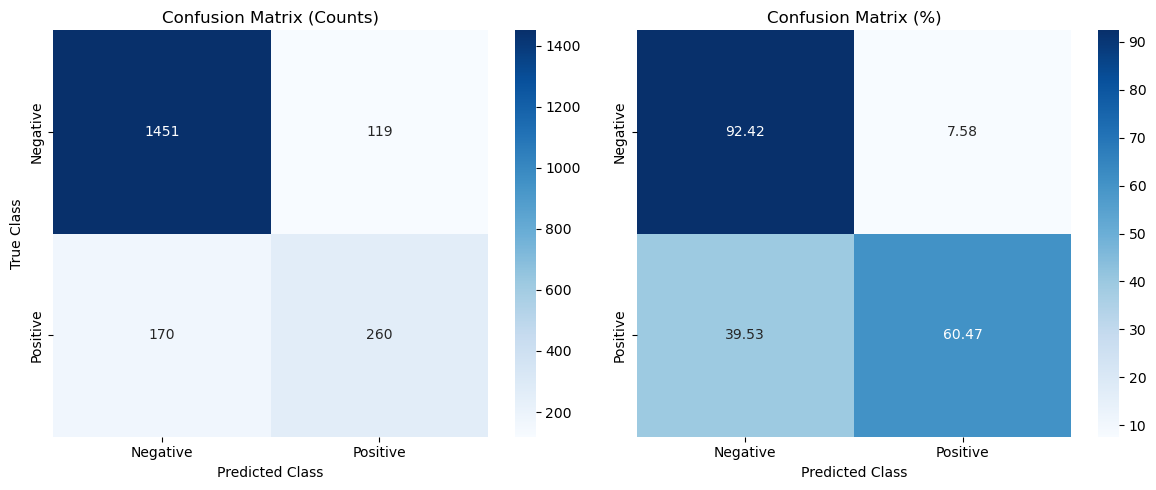

In [23]:
# Define figure size for side-by-side confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Define class names
class_names = ["Negative", "Positive"]

# Plot first confusion matrix (raw values)
sns.heatmap(cm_BDT, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title("Confusion Matrix (Counts)")
axes[0].set_xlabel("Predicted Class")
axes[0].set_ylabel("True Class")

# Plot second confusion matrix (percentages)
sns.heatmap(cm_percentage_BDT, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title("Confusion Matrix (%)")
axes[1].set_xlabel("Predicted Class")

# Adjust layout
plt.tight_layout()
plt.show()

To understand _why_ the BDT makes these decisions we can use a **SHAP Explainer** and visualise some insights.  Below it is clear that as predicted early on, the Number of Products a customer uses has a major impact on their probability to churn, with customers than use more products more likely to leave.  It's clear that the customers' Age, activity levels and account balance also all have major impacts.  Interestingly, the BDT does not select heavily on the geography of the customer.  While it remains true that customers in Germany are far more likely to churn that customers in other countries, the SHAP explanation is that the causal indicators are customers' age, wealth, activity levels and product use. This may indicate a subset of customers who are highly engaged and may expect VIP treatment.
- <span style="color:red">**Business action**:</span>  Focus on high-balance customers with multiple products, consider exclusive benefits to retain their business.

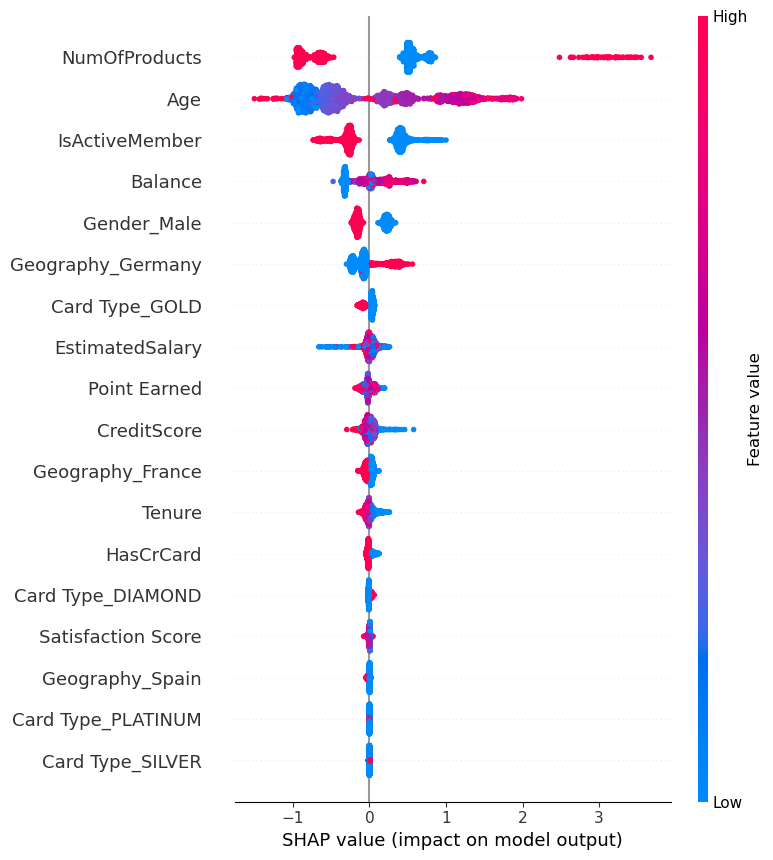

In [24]:
X_cv_df = pd.DataFrame(X_cv_norm, columns=features_df.columns)

shap_explainer_BDT = shap.Explainer(best_model_BDT, X_cv_df)

shap_values_BDT = shap_explainer_BDT(X_cv_df)

shap.summary_plot(shap_values_BDT, X_cv_df)

### Error Analysis on BDT

For future improvements, it is informative to understand where the BDT falls short in making predictions.  Below I plot again the input features, but this time only for customers who churned, and separated by the predictions of the BDT on whether or not they would churn. These plots represent the test data only. From the separation in these plots, it appears that the BDT may rely too heavily on the age of the customer as a predictor for churning.  The majority of churning customers incorrectly classified were below the age of 45. This indicates that focusing more on account balance and the number of products used is an important way to progress.

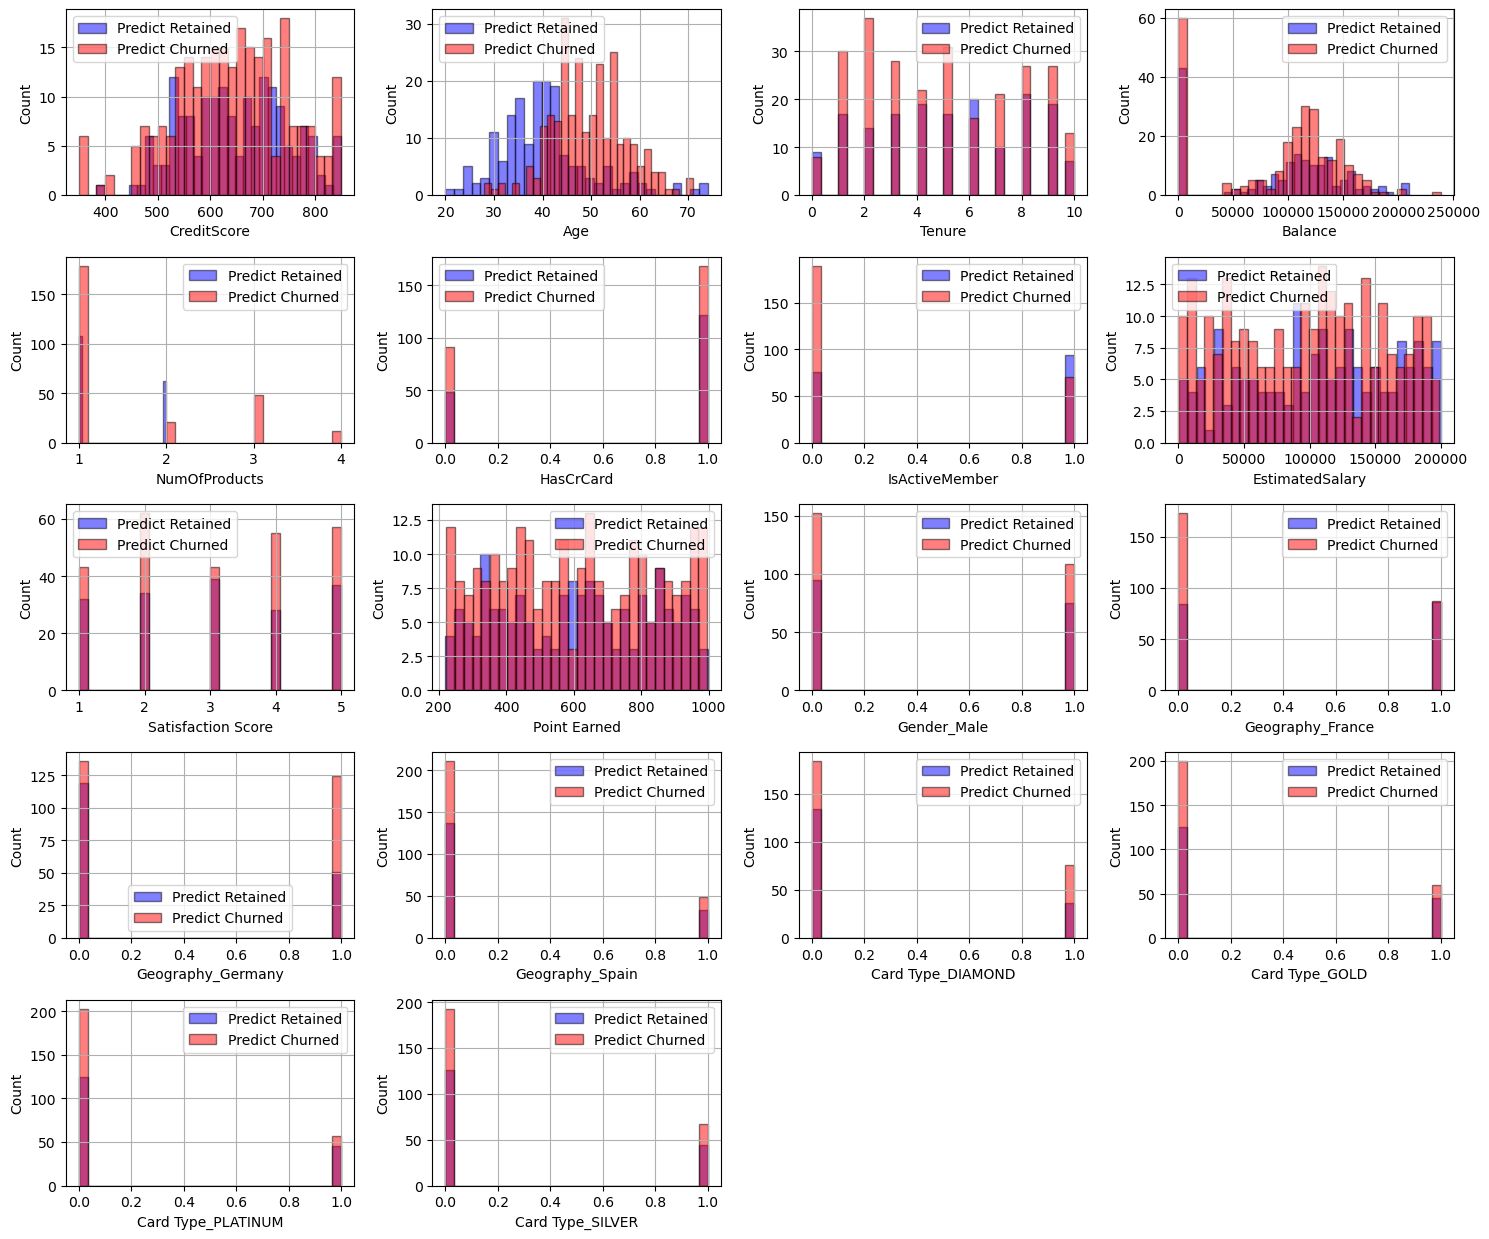

In [25]:
#let's use subplots to make a load of comparisons side by side - this time for histograms
num_features = len(features_df.columns)
num_cols = 4
num_rows = math.ceil(num_features / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize = (15, 2.5* num_rows))

axes = axes.flatten() if num_features > 1 else [axes]

for i, feature in enumerate(X_test.columns):
    pred_exited_0 = X_test.loc[(y_test==1) & (y_test_pred_BDT==0),feature]
    pred_exited_1 = X_test.loc[(y_test==1) & (y_test_pred_BDT==1),feature]
    
    axes[i].hist(pred_exited_0, bins=30, color='blue', edgecolor='black', alpha=0.5, label="Predict Retained")
    axes[i].hist(pred_exited_1, bins=30, color='red', edgecolor='black', alpha=0.5, label="Predict Churned")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Count")
    axes[i].set_title=(f"Histogram of {feature} by Predicted Client Status")
    axes[i].legend()
    axes[i].grid(True)

#hide any unecessary subplots (i.e. num_features doesn't fit perfectly into num_rows*num_cols)   
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Training a Neural Network with hyperparameter optimisation

As an explorative comparison, I have used [Tensorflow](https://www.tensorflow.org/) to train a Neural Network (NN) binary classifier, while again using [Optuna](https://optuna.org/) for the optimisation of hyperparameters.

For the NN I opt to use a custom Focal Loss loss-function take into account the 1:4 class imbalance in the data.  This teaches the NN to put greater emphasis on getting the Positive Class (churn) cases correct, rather than the Negative Class (retained) where it has more data.

I use Optuna to optimise the following parameters:
- Balancing Factor: Increases the weight of Positive Class (churn) examples in the training process, to improve the focus with an imbalanced dataset
- Focusing Factor: Supression of 'easy' examples, to focus instead on difficult misclassified cases
- Number of layers: The depth of the NN, balancing complexity with over-fitting
- Number of nodes: The width of each hidden layer in the NN, balancing complexity with over-fitting
- Activation function: Introducing non-linearity to the network: relu, leaky relu, or tanh activations
- Learning Rate: How much the NN updates weights per epoch, balancing training speed with stability
- Maximum Epochs: How many times the model observes the full dataset, balancing against over-fitting

In addition, I use Optuna to optimise these hyperparameters based on maximising the Precision-Recall Area Under Curve (PR-AUC), with an extra reward term for higher Recall to further address the class imbalance. This is to focus the model even further on correctly identifying churners while maintaining strong precision.

In [26]:
#Implement a FocalLoss() loss function

def focal_loss(alpha,gamma):
    def loss(y_true, y_pred):
        #Convert logits to probabilities using sigmoid
        y_pred = tf.nn.sigmoid(y_pred)

        #cCompute focal loss
        prob_true = y_true * y_pred + (1-y_true)*(1-y_pred) #probability of true class
        focal_weight = alpha * tf.keras.backend.pow(1.0 - prob_true, gamma) #weight for harder cases to classifier (true positives)

        return tf.keras.backend.mean(focal_weight * tf.keras.backend.binary_crossentropy(y_true, y_pred)) #Weighted BCE
    return loss

In [27]:
#Optimise hyperparameters with Optuna
#Employ early stopping as well since we keep getting models which are overfitting

def objective_NN(trial):
    tf.keras.backend.clear_session() #reset TF for reproducibility
    
    #define the model
    model = Sequential()

    # Input layer (fixed to number of features)
    model.add(Dense(
        units=num_features,  # Matches number of input features
        activation="relu",
        input_shape=(num_features,)
    ))

    #tune number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1, 4)

    for i in range(num_layers):
        model.add(Dense(
            units=trial.suggest_int(f"units_{i}", 16, 64, step=16), #tune neuron counts
            activation=trial.suggest_categorical(f"activation_{i}", ["relu", "tanh", "leaky_relu"])
        ))

    #output layer
    model.add(Dense(1,  activation="linear"))

    #let optuna tune the new FocalLoss methodology class imbalance
    class_alpha = trial.suggest_float("class_alpha", 0.3, 0.7)

    #let optuna tune the new FocalLoss methodology class focus
    class_gamma = trial.suggest_int("class_gamma",1,3)
    
    #compile model with tuneable learning rate
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=focal_loss(class_alpha, class_gamma),
        metrics=[
            tf.keras.metrics.AUC(curve="PR",name="PR_AUC"),
            tf.keras.metrics.Recall(name="val_recall")
        ]  # Use AUC for imbalanced data
    )

    early_stopping = EarlyStopping(
        monitor="val_PR_AUC",  # Stop when AUC stops improving
        patience=5,  # Wait for 5 epochs before stopping
        restore_best_weights=True,  # Restore the best weights after stopping
        mode="max",  # AUC should be maximized
        min_delta=0.001
    )

    #we're going to optimise the number of epochs too
    max_epochs = trial.suggest_int("max_epochs",10, 50, step=5)
    
    #train with class weights
    history = model.fit(
        X_norm, y_train,
        epochs = max_epochs,
        validation_data=(X_cv_norm, y_cv),
        #class_weight=class_weight_dict, #drop class weights for now
        callbacks=[early_stopping],
        batch_size = 32, #ease memory useage and disk pressure
        verbose = 0
    )

    pr_auc = max(history.history["val_PR_AUC"])
    recall = max(history.history["val_recall"])  # Add recall tracking
    
    return pr_auc + 0.1 * recall  # Weight recall in the objective function

In [28]:
#Run Optuna
study_NN = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=SEED))  # PR_AUC should be maximized
study_NN.optimize(objective_NN, n_trials=20)  # Try 20 different hyperparameter sets

In [29]:
best_params_NN= study_NN.best_params
# Print the best hyperparameters
print("Best NN Hyperparameters Found:")
print(study_NN.best_params)

Best NN Hyperparameters Found:
{'num_layers': 3, 'units_0': 32, 'activation_0': 'tanh', 'units_1': 48, 'activation_1': 'leaky_relu', 'units_2': 16, 'activation_2': 'tanh', 'class_alpha': 0.39082502614981296, 'class_gamma': 1, 'learning_rate': 0.009900261076950743, 'max_epochs': 50}


In [30]:
#Let's build a model using these optimised parameters

tf.keras.backend.clear_session() #reset TF for reproducibility

# Start with a new model
best_model_NN = Sequential()

# Input layer (fixed to number of features)
best_model_NN.add(Dense(
    units=num_features,
    activation="relu",
    input_shape=(num_features,)
))

# Add the optimal number of hidden layers
for i in range(best_params_NN["num_layers"]):
    best_model_NN.add(Dense(
        units=best_params_NN[f"units_{i}"],  
        activation=best_params_NN[f"activation_{i}"]
    ))

# Output layer (logits for binary classification)
best_model_NN.add(Dense(1, activation="linear"))  

# Compile with the best learning rate
best_model_NN.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params_NN["learning_rate"]),
    loss=focal_loss(best_params_NN["class_alpha"], best_params_NN["class_gamma"]),
    metrics=[
        tf.keras.metrics.AUC(curve="PR",name="PR_AUC"),
        tf.keras.metrics.Recall(name="recall") # Use AUC for imbalanced data
    ]
)

In [31]:
#let's train this model with the optimised hyperparameters

early_stopping = EarlyStopping(
    monitor="val_PR_AUC",
    patience=5,  
    restore_best_weights=True,
    mode="max",
    min_delta=0.001
)

history_NN = best_model_NN.fit(
    X_norm, y_train,
    epochs=best_params_NN["max_epochs"],
    validation_data=(X_cv_norm, y_cv),
    #class_weight=class_weight_dict,  # Balance class weights #Disable as we're using FocalLoss() now
    callbacks=[early_stopping],
    batch_size = 32,
    verbose=0
)

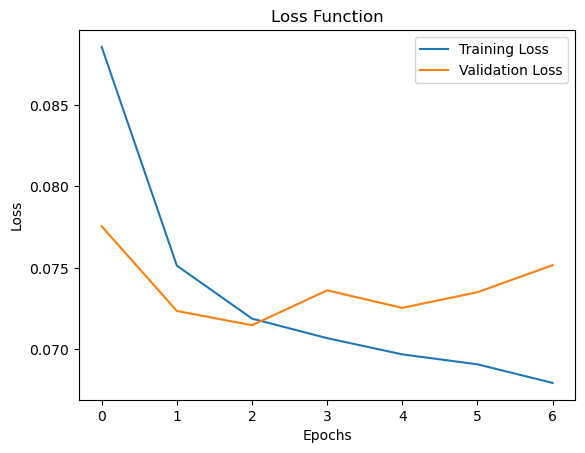

In [32]:
#Let's draw the loss functions using the history
plt.plot(history_NN.history['loss'], label = 'Training Loss')
if 'val_loss' in history_NN.history:
    plt.plot(history_NN.history['val_loss'], label = 'Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function')
plt.legend()
plt.show()

In [33]:
best_epoch_NN = np.argmax(history_NN.history["val_PR_AUC"]) + 1  # Get 1-based epoch number
best_val_auc_NN = max(history_NN.history["val_PR_AUC"])

print(f"Best Epoch: {best_epoch_NN}, Best Validation AUC: {best_val_auc_NN:.4f}")

Best Epoch: 2, Best Validation AUC: 0.5617


Having trained the model, we can now consider the NN output score as a proability for a customer to churn.  We have freedom to interpret this score and to set the threshold above which we consider the probability to churn to be high enough to classifying this customer in the Positive class. For this I again implement the F1-score, which gives the optimal balance between the Precision and Recall of the algorithm.

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Optimal Threshold (Precision ≈ Recall): 0.4261


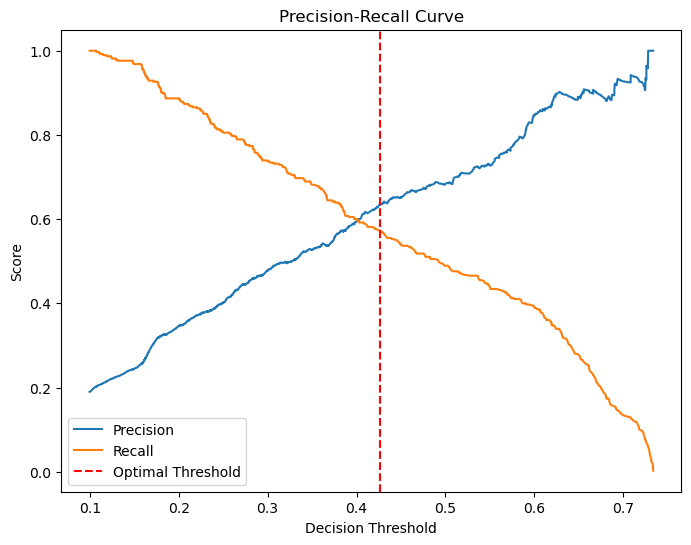

In [34]:
y_cv_pred_NN = best_model_NN.predict(X_cv_norm)
y_cv_pred_prob_NN = tf.sigmoid(y_cv_pred_NN).numpy().flatten()

# Compute Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_cv, y_cv_pred_prob_NN)

# Compute F1-score for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
optimal_threshold = thresholds[np.argmax(f1_scores)]

print(f"Optimal Threshold (Precision ≈ Recall): {optimal_threshold:.4f}")

# Plot Precision-Recall Curve
plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.axvline(x=optimal_threshold, color="r", linestyle="--", label="Optimal Threshold")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision-Recall Curve")
plt.show()

It is also valuable to visualise this optimal threshold directly in the data itself as a function of True Positive and True Negative cases, to get an additional feel for how modifying this threshold further might affect the overall precision and recall.

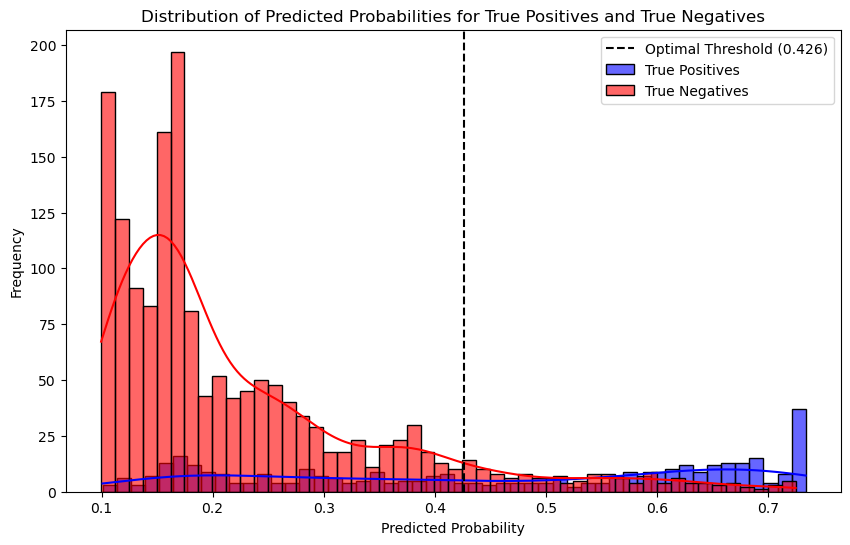

In [35]:
#What do the y_cv prediction probabilities look like compared with the truth?

true_pos_NN = y_cv_pred_prob_NN[y_cv == 1]
true_neg_NN = y_cv_pred_prob_NN[y_cv == 0]

plt.figure(figsize=(10, 6))
sns.histplot(true_pos_NN, bins=50, kde=True, color="blue", label="True Positives", alpha=0.6)
sns.histplot(true_neg_NN, bins=50, kde=True, color="red", label="True Negatives", alpha=0.6)

# Plot vertical line at optimal threshold
plt.axvline(x=optimal_threshold, color='black', linestyle='--', label=f"Optimal Threshold ({optimal_threshold:.3f})")

# Labels and title
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities for True Positives and True Negatives")
plt.legend()
plt.show()

With the optimal decision threshold, it is now straight forward to use the NN to make predictions for every customer in the dataset and consider the overall performance of the NN. The scores below again indicate a very slight over-training of the algorithm, which could be mitigated through further optimisation. The variance is high, which may be due to a lack of enough data.

In [36]:
y_train_pred_NN = best_model_NN.predict(X_norm)
y_train_pred_prob_NN = tf.sigmoid(y_train_pred_NN).numpy().flatten()
auc_train_score_NN = roc_auc_score(y_train, y_train_pred_prob_NN)
y_train_pred_class_NN = (y_train_pred_prob_NN >= optimal_threshold).astype(int)

y_cv_pred_NN = best_model_NN.predict(X_cv_norm)
y_cv_pred_prob_NN = tf.sigmoid(y_cv_pred_NN).numpy().flatten()
auc_cv_score_NN = roc_auc_score(y_cv, y_cv_pred_prob_NN)
y_cv_pred_class_NN = (y_cv_pred_prob_NN >= optimal_threshold).astype(int)

y_test_pred_NN = best_model_NN.predict(X_test_norm)
y_test_pred_prob_NN = tf.sigmoid(y_test_pred_NN).numpy().flatten()
auc_test_score_NN = roc_auc_score(y_test, y_test_pred_prob_NN)
y_test_pred_class_NN = (y_test_pred_prob_NN >= optimal_threshold).astype(int)

# Training Set Metrics
train_acc_NN = accuracy_score(y_train, y_train_pred_class_NN)
train_precision_NN = precision_score(y_train, y_train_pred_class_NN)
train_recall_NN = recall_score(y_train, y_train_pred_class_NN)
train_f1_NN = f1_score(y_train, y_train_pred_class_NN)

# Cross-Validation Set Metrics
cv_acc_NN = accuracy_score(y_cv, y_cv_pred_class_NN)
cv_precision_NN = precision_score(y_cv, y_cv_pred_class_NN)
cv_recall_NN = recall_score(y_cv, y_cv_pred_class_NN)
cv_f1_NN = f1_score(y_cv, y_cv_pred_class_NN)

# Test Set Metrics
test_acc_NN = accuracy_score(y_test, y_test_pred_class_NN)
test_precision_NN = precision_score(y_test, y_test_pred_class_NN)
test_recall_NN = recall_score(y_test, y_test_pred_class_NN)
test_f1_NN = f1_score(y_test, y_test_pred_class_NN)


# Create a dictionary of model scores
metrics_data_NN = {
    "Dataset": ["Training", "Cross-Validation", "Test"],
    "Accuracy": [train_acc_NN, cv_acc_NN, test_acc_NN],
    "Precision": [train_precision_NN, cv_precision_NN, test_precision_NN],
    "Recall": [train_recall_NN, cv_recall_NN, test_recall_NN],
    "F1-Score": [train_f1_NN, cv_f1_NN, test_f1_NN],
    "ROC-AUC": [auc_train_score_NN, auc_cv_score_NN, auc_test_score_NN]
}

# Convert to DataFrame
df_metrics_NN = pd.DataFrame(metrics_data_NN)

# Convert to Markdown table format
markdown_table_NN = df_metrics_NN.to_markdown(index=False, floatfmt=".4f")

# Display in Jupyter Notebook
display(Markdown(markdown_table_NN))

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


| Dataset          |   Accuracy |   Precision |   Recall |   F1-Score |   ROC-AUC |
|:-----------------|-----------:|------------:|---------:|-----------:|----------:|
| Training         |     0.8488 |      0.6394 |   0.5993 |     0.6187 |    0.8575 |
| Cross-Validation |     0.8455 |      0.6035 |   0.5447 |     0.5726 |    0.8246 |
| Test             |     0.8370 |      0.6307 |   0.5837 |     0.6063 |    0.8450 |

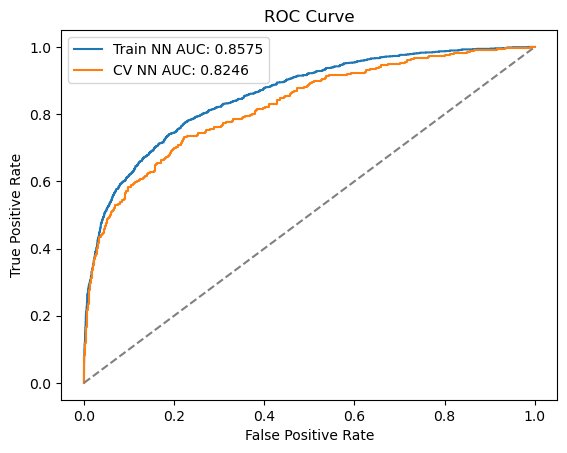

In [37]:
# Compute AUC Score
train_auc_NN = roc_auc_score(y_train, y_train_pred_prob_NN)
cv_auc_NN = roc_auc_score(y_cv, y_cv_pred_prob_NN)

# ROC Curve
fpr_train_NN, tpr_train_NN, _ = roc_curve(y_train, y_train_pred_prob_NN)
fpr_cv_NN, tpr_cv_NN, _ = roc_curve(y_cv, y_cv_pred_prob_NN)

plt.plot(fpr_train_NN, tpr_train_NN, label=f"Train NN AUC: {train_auc_NN:.4f}")
plt.plot(fpr_cv_NN, tpr_cv_NN, label=f"CV NN AUC: {cv_auc_NN:.4f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")  # Random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


For binary classification problems Confusion Matrices are valuable tools for quickly understanding the performance of the classification decisions. The NN does a fantastic job of surpressing False Positives, only mis-classifying 9.4% of True Negatives.  It is also able to successfully classify 58.4% of True Positives, meaning the performance is slightly stricter than the BDT performance overall.

In [38]:
#Confusion matrix
cm_NN = confusion_matrix(y_test, y_test_pred_class_NN)
cm_percentage_NN = 100* cm_NN.astype("float") / cm_NN.sum(axis=1, keepdims=True)

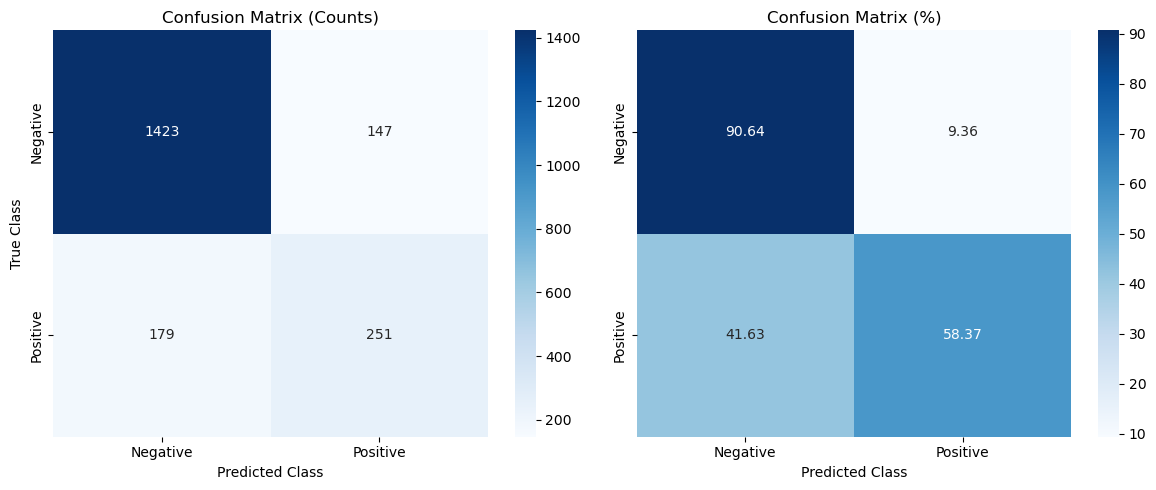

In [39]:
# Define figure size for side-by-side confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Define class names
class_names = ["Negative", "Positive"]

# Plot first confusion matrix (raw values)
sns.heatmap(cm_NN, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title("Confusion Matrix (Counts)")
axes[0].set_xlabel("Predicted Class")
axes[0].set_ylabel("True Class")

# Plot second confusion matrix (percentages)
sns.heatmap(cm_percentage_NN, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title("Confusion Matrix (%)")
axes[1].set_xlabel("Predicted Class")

# Adjust layout
plt.tight_layout()
plt.show()

To understand _why_ the NN makes the decisions it does, we can again use a **SHAP Explainer** to visualise some insights.  Below it is clear that as predicted early on, the Number of Products a customer uses has a major impact on their probability to churn, with customers than use more products more likely to leave.  It's clear that the customers' Age, activity levels and account balance also all have major impacts.  Compared to ther BDT, the NN puts greater emphasis on the geography of the customer, highlighting that customers in Germany are more likely to churn than customers in other countries. Overall however the SHAP explanation is the same, the causal indicators are customers' age, wealth, activity levels and product use.  This further supports the theory indicating a subset of customers who are highly engaged and may expect VIP treatment.

- <span style="color:red">**Business action**:</span>  Focus on high-balance customers with multiple products, consider exclusive benefits to retain their business.

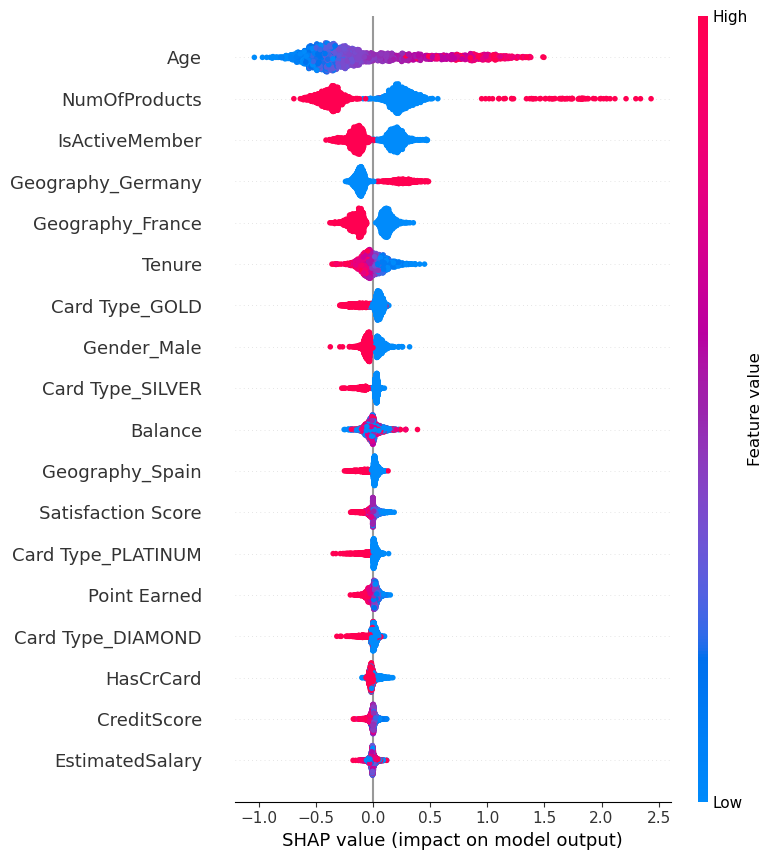

In [40]:
shap_explainer_NN = shap.Explainer(best_model_NN, X_cv_df)

shap_values_NN = shap_explainer_NN(X_cv_df)

shap.summary_plot(shap_values_NN, X_cv_df)

### Error Analysis on NN

For future improvements, it is informative to understand where the NN falls short in making predictions.  Below I plot again the input features, but this time only for customers who churned, and separated by the predictions of the NN on whether or not they would churn. These plots represent the test data only. From the separation in these plots, it appears that, like the BDT, the NN may rely too heavily on the age of the customer as a predictor for churning. The majority of churning customers incorrectly classified were below the age of 45. This indicates that focusing more on account balance and the number of products used is an important way to progress.

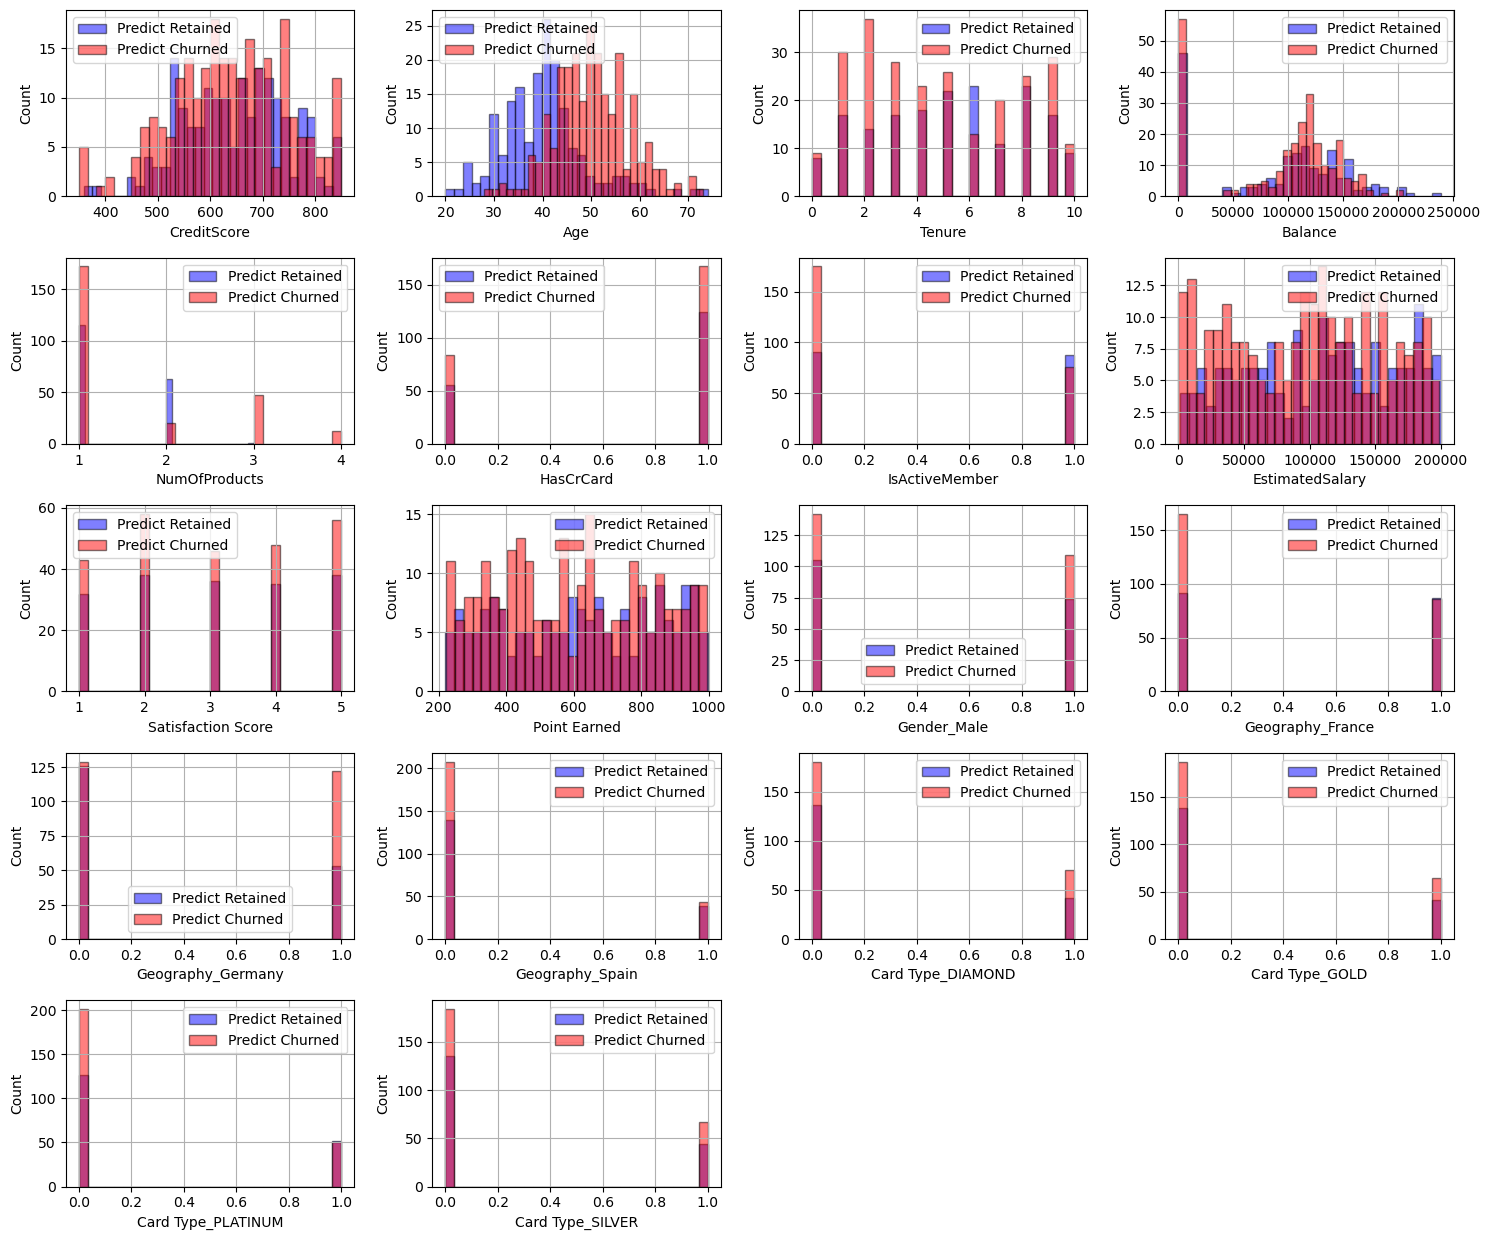

In [41]:
#let's use subplots to make a load of comparisons side by side - this time for histograms
num_features = len(features_df.columns)
num_cols = 4
num_rows = math.ceil(num_features / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize = (15, 2.5* num_rows))

axes = axes.flatten() if num_features > 1 else [axes]

for i, feature in enumerate(X_test.columns):
    pred_exited_0 = X_test.loc[(y_test==1) & (y_test_pred_class_NN==0),feature]
    pred_exited_1 = X_test.loc[(y_test==1) & (y_test_pred_class_NN==1),feature]
    
    axes[i].hist(pred_exited_0, bins=30, color='blue', edgecolor='black', alpha=0.5, label="Predict Retained")
    axes[i].hist(pred_exited_1, bins=30, color='red', edgecolor='black', alpha=0.5, label="Predict Churned")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Count")
    axes[i].set_title=(f"Histogram of {feature} by Predicted Client Status")
    axes[i].legend()
    axes[i].grid(True)

#hide any unecessary subplots (i.e. num_features doesn't fit perfectly into num_rows*num_cols)   
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()